#### Imports/L5Kit environment setup

In [91]:
import matplotlib.pyplot as plt
import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data

import os

In [92]:
# opening the zarr_dataset
os.environ["L5KIT_DATA_FOLDER"] = "../../prediction-dataset/"
os.environ["L5KIT_DATA_FOLDER"] = "../prediction-sample-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

In [93]:
# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

#### Kalman Filter Setup Function

In [94]:
# kalmanFilterSetup() sets up the matrices needed to use the multivariate Kalman Filter
def kalmanFilterSetup():

    # setting up matrices for Kalman Filter
    # initial state matrix, "unknown" vehicle location so we set pos, vel, acc to 0
    x = np.array([[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]])

    # since velocity and acceleration is unknown, a high estimate uncertainty is set, resulting in a high Kalman Gain
    # calculate these values
    P = np.array([[100, 0, 0, 0, 0, 0],
                  [0, 80, 0, 0, 0, 0],
                  [0, 0, 10, 0, 0, 0],
                  [0, 0, 0, 100, 0, 0],
                  [0, 0, 0, 0, 80, 0],
                  [0, 0, 0, 0, 0, 10]])

    # t = measurement period in seconds
    t = 1
    acc_std_dev = 0.2

    # state transition matrix, kinematic equations for position, velocity, and acceleration
    F = np.array([[1, t, 0.5*(t**2), 0, 0,          0], 
                  [0, 1,          t, 0, 0,          0], 
                  [0, 0,          1, 0, 0,          0], 
                  [0, 0,          0, 1, t, 0.5*(t**2)], 
                  [0, 0,          0, 0, 1,          t], 
                  [0, 0,          0, 0, 0,          1]])

    # process noise matrix
    Q = np.array([[0.25, 0.5, 0.5,    0,   0,   0], 
                  [ 0.5,   1,   1,    0,   0,   0], 
                  [ 0.5,   1,   1,    0,   0,   0],
                  [   0,   0,   0, 0.25, 0.5, 0.5],
                  [   0,   0,   0,  0.5,   1,   1],
                  [   0,   0,   0,  0.5,   1,   1]]) * (acc_std_dev**2)

    # measurement error variance
    xvar = 30
    yvar = 30
    
    # measurement uncertainty matrix
    R = np.array([[xvar, 0], 
                  [0, yvar]])

    H = np.array([[1, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 1, 0, 0]])

    I = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])

    # initialization
    P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q
    
    return(x, F, P, R, H, Q, I,)

#### Kalman Filter setup with initial position

In [95]:


# kalmanFilterSetup() sets up the matrices needed to use the multivariate Kalman Filter
def kalmanFilterSetupPos(initial_position):

    # setting up matrices for Kalman Filter
    # initial state matrix, "unknown" vehicle location so we set pos, vel, acc to 0
    x = np.array([[initial_position[0]],
                  [0],
                  [0],
                  [initial_position[1]],
                  [0],
                  [0]])

    # since velocity and acceleration is unknown, a high estimate uncertainty is set, resulting in a high Kalman Gain
    # calculate these values
    P = np.array([[100, 0, 0, 0, 0, 0],
                  [0, 80, 0, 0, 0, 0],
                  [0, 0, 10, 0, 0, 0],
                  [0, 0, 0, 100, 0, 0],
                  [0, 0, 0, 0, 80, 0],
                  [0, 0, 0, 0, 0, 10]])

    # t = measurement period in seconds
    t = 1
    acc_std_dev = 0.2

    # state transition matrix, kinematic equations for position, velocity, and acceleration
    F = np.array([[1, t, 0.5*(t**2), 0, 0,          0], 
                  [0, 1,          t, 0, 0,          0], 
                  [0, 0,          1, 0, 0,          0], 
                  [0, 0,          0, 1, t, 0.5*(t**2)], 
                  [0, 0,          0, 0, 1,          t], 
                  [0, 0,          0, 0, 0,          1]])

    # process noise matrix
    Q = np.array([[0.25, 0.5, 0.5,    0,   0,   0], 
                  [ 0.5,   1,   1,    0,   0,   0], 
                  [ 0.5,   1,   1,    0,   0,   0],
                  [   0,   0,   0, 0.25, 0.5, 0.5],
                  [   0,   0,   0,  0.5,   1,   1],
                  [   0,   0,   0,  0.5,   1,   1]]) * (acc_std_dev**2)

    # measurement error variance
    xvar = 30
    yvar = 30
    
    # measurement uncertainty matrix
    R = np.array([[xvar, 0], 
                  [0, yvar]])

    H = np.array([[1, 0, 0, 0, 0, 0], 
                  [0, 0, 0, 1, 0, 0]])

    I = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])

    # initialization
    P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q
    
    return(x, F, P, R, H, Q, I,)

#### Kalman Filter Function

In [96]:
# kalmanFilter() implements the Kalman Filter on the inputted measurements for the given number of iterations
def kalmanFilter(positions, output):
    estimates = []
    predictions = []

    x, F, P, R, H, Q, I = kalmanFilterSetup()

    for i in range(len(positions)):
        z = np.array([[positions[i][0]],
                      [positions[i][1]]])
        if output: print(z)
        
        # Kalman Gain calculation
        # K = (P * H_T) * (H * P * H_T + R)^-1
        K = np.matmul(np.matmul(P, np.transpose(H)), 
                      np.linalg.inv(np.matmul(np.matmul(H, P), np.transpose(H)) + R))
        if output: print(K)

        # current state estimation
        # x = x + K * (z - H * x)
        x = x + np.matmul(K, (z - np.matmul(H, x)))
        estimates.append([x[0][0],x[3][0]])
        if output: print(x)

        # update estimate uncertainty
        # P = (I - K * H) * P * (I - K * H)_T + K * R * K_T
        # IKH = (I - K * H)
        IKH = I - np.matmul(K, H)
        P = np.matmul(np.matmul(IKH, P), np.transpose(IKH)) + np.matmul(np.matmul(K, R), np.transpose(K))
        if output: print(P)

        # predict state and update estimate uncertainty
        # x = F * x
        # P = F * P * F_T + Q
        x = np.matmul(F, x)
        P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q 
        predictions.append([x[0][0],x[3][0]])
        if output: print(x)
        if output: print(P)

    # formatting
    estimates = np.array(estimates)
    predictions = np.array(predictions)
    
    return (estimates, predictions)

#### Kalman Filter with initial position

In [97]:
def kalmanFilterPos(positions, output):
    estimates = []
    predictions = []

    x, F, P, R, H, Q, I = kalmanFilterSetupPos(positions[0])

    for i in range(len(positions)):
        z = np.array([[positions[i][0]],
                      [positions[i][1]]])
        if output: print(z)
        
        # Kalman Gain calculation
        # K = (P * H_T) * (H * P * H_T + R)^-1
        K = np.matmul(np.matmul(P, np.transpose(H)), 
                      np.linalg.inv(np.matmul(np.matmul(H, P), np.transpose(H)) + R))
        if output: print(K)

        # current state estimation
        # x = x + K * (z - H * x)
        x = x + np.matmul(K, (z - np.matmul(H, x)))
        estimates.append([x[0][0],x[3][0]])
        if output: print(x)

        # update estimate uncertainty
        # P = (I - K * H) * P * (I - K * H)_T + K * R * K_T
        # IKH = (I - K * H)
        IKH = I - np.matmul(K, H)
        P = np.matmul(np.matmul(IKH, P), np.transpose(IKH)) + np.matmul(np.matmul(K, R), np.transpose(K))
        if output: print(P)

        # predict state and update estimate uncertainty
        # x = F * x
        # P = F * P * F_T + Q
        x = np.matmul(F, x)
        P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q 
        predictions.append([x[0][0],x[3][0]])
        if output: print(x)
        if output: print(P)

    # formatting
    estimates = np.array(estimates)
    predictions = np.array(predictions)
    
    return (estimates, predictions)

#### Storing frame indices for each scene

In [98]:
scene_frame_indices = []
scene_frame_indices = zarr_dataset.scenes[:]["frame_index_interval"]

#### Plotting function

In [99]:
def plotData(measurements):
    
    estimates_pos, predictions_pos = kalmanFilterPos(measurements, output=False)
    estimates, predictions = kalmanFilter(measurements, output=False)

    measurements_x = [pos[0] for pos in measurements]
    measurements_y = [pos[1] for pos in measurements]

    estimates_x = [estimate[0] for estimate in estimates]
    estimates_y = [estimate[1] for estimate in estimates]

    predictions_x = [prediction[0] for prediction in predictions]
    predictions_y = [prediction[1] for prediction in predictions]

    estimates_x_pos = [estimate[0] for estimate in estimates_pos]
    estimates_y_pos = [estimate[1] for estimate in estimates_pos]

    predictions_x_pos = [prediction[0] for prediction in predictions_pos]
    predictions_y_pos = [prediction[1] for prediction in predictions_pos]

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    ax = plt.subplot(1, 3, 1)
    ax.scatter(measurements_x, measurements_y, label="Positions", s=5, alpha=1, color='c')
    ax.legend()
    ax.set_title("Position Data")
    ax.set_xlabel("Position (m)")
    ax.set_ylabel("Position (m)")

    ax1 = plt.subplot(1, 3, 2)
    ax1.scatter(measurements_x, measurements_y, label="Positions", s=5, alpha=0.5, color='c')
    ax1.scatter(predictions_x, predictions_y, label="Predictions", s=5, alpha=0.3, color='m')
    ax1.legend()
    ax1.set_title("Basic Kalman Filter")
    
    ax2 = plt.subplot(1, 3, 3)
    ax2.scatter(measurements_x, measurements_y, label="Positions", s=5, alpha=0.5, color='c')
    ax2.scatter(predictions_x_pos, predictions_y_pos, label="Predictions", s=5, alpha=0.3, color='m')
    ax2.legend()
    ax2.set_title("Filter with Initial Position")
    
    # https://stackoverflow.com/questions/38855748/matplotlib-generating-strange-y-axis-on-certain-data-sets
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax1.get_yaxis().get_major_formatter().set_useOffset(False)
    ax2.get_yaxis().get_major_formatter().set_useOffset(False)


    plt.tight_layout()
    plt.show()

#### Function to compare Kalman Filter and Kalman-Filter-with-initial-position

In [100]:
def compareFilters(scene_number):
    positions = zarr_dataset.frames[slice(scene_frame_indices[scene_number][0], scene_frame_indices[scene_number][1])]["ego_translation"]
    positions = [[pos[0], pos[1]] for pos in positions]

    plotData(positions)

#### Plots

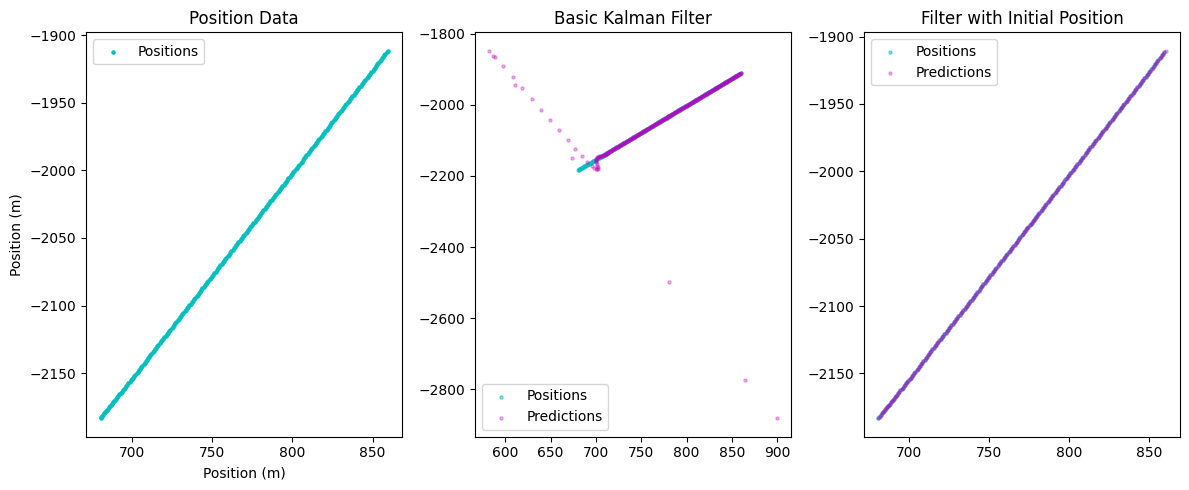

In [101]:
compareFilters(0)

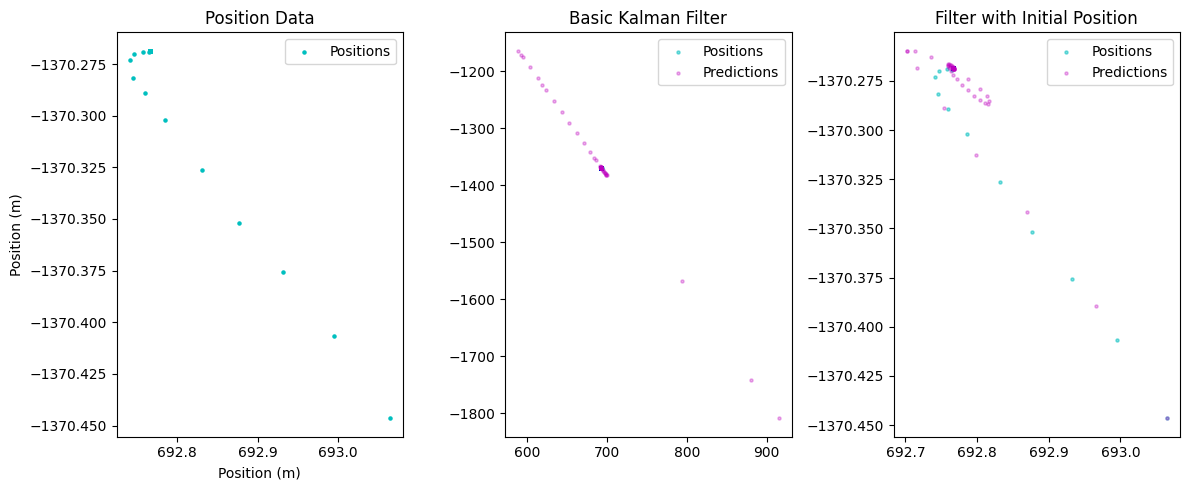

In [102]:
compareFilters(2)

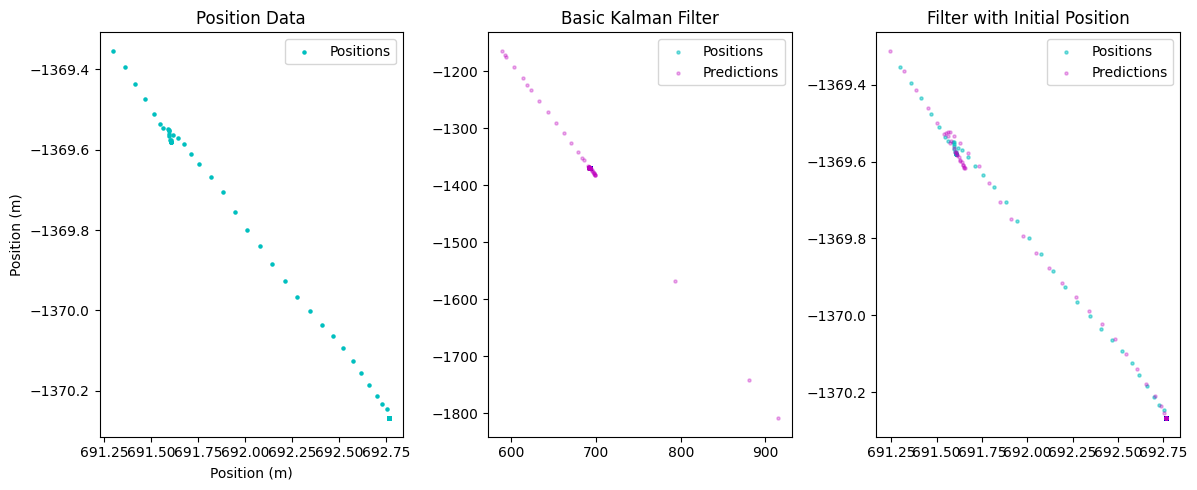

In [103]:
compareFilters(5)

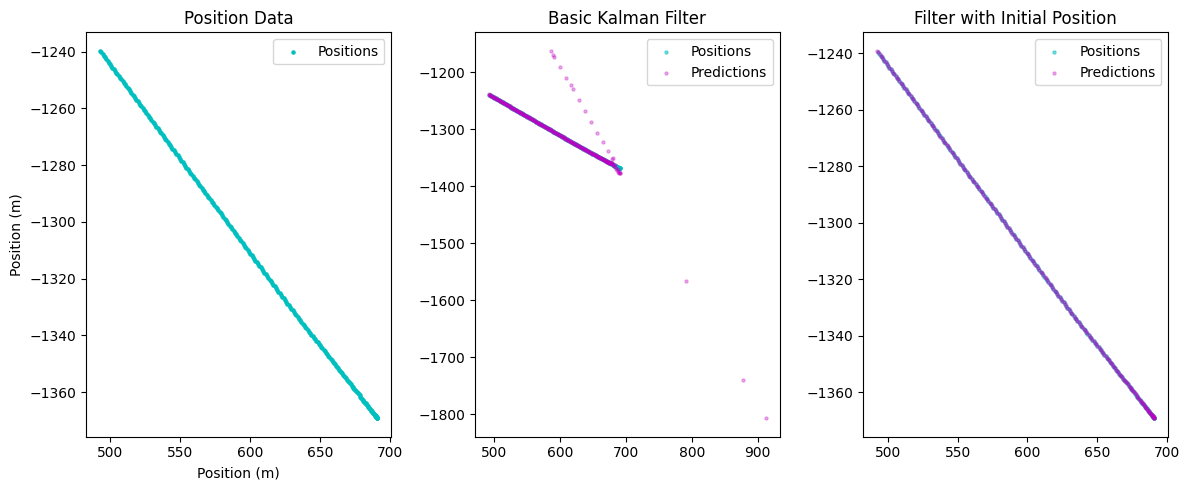

In [104]:
compareFilters(6)

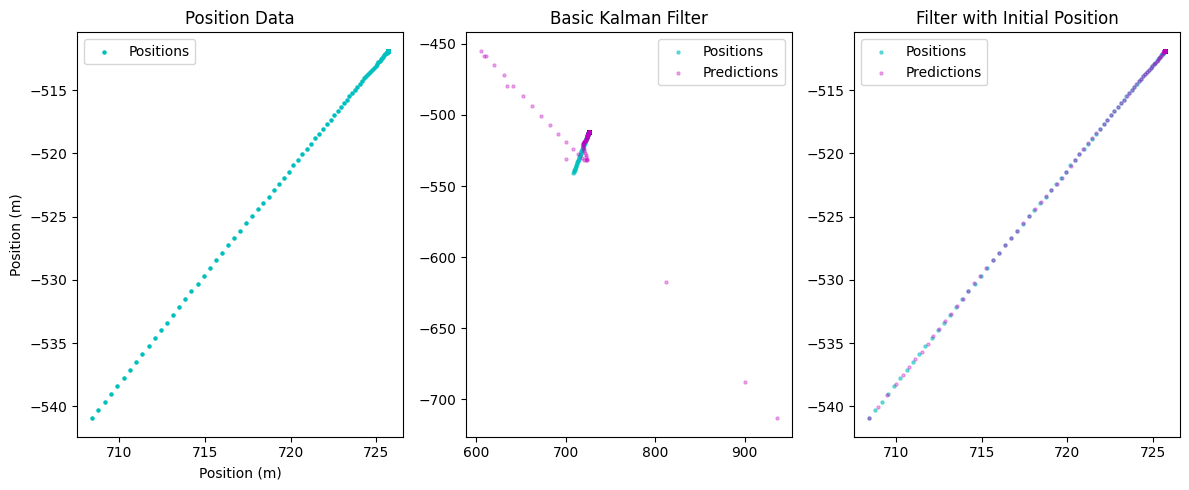

In [105]:
compareFilters(60)

#### Mean-squared error

In [106]:
def mse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    return np.square(np.subtract(position, prediction)).mean(axis=0)

#### 1/r weighted mean-squared error

In [107]:
# https://www.geeksforgeeks.org/how-to-implement-weighted-mean-square-error-in-python/#:~:text=Weighted%20mean%20square%20error%20enables,be%20a%20vital%20performance%20metric.
def oneRWmse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    weights = np.array([1/(len(position)-x) for x in range(len(position))])
    weights = weights/weights.sum()
    weights = [[weight, weight] for weight in weights]

    return (np.square(np.subtract(position, prediction))*weights).sum(axis=0)

#### Rational weighted mean-squared error

In [108]:
def RWmse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    weights = np.array([x/(x+1) for x in range(1, len(position) + 1)])
    weights = weights/weights.sum()
    weights = [[weight, weight] for weight in weights]

    return (np.square(np.subtract(position, prediction))*weights).sum(axis=0)

#### Calculating error

In [109]:
#mse = (1/n) * sum(actual-prediction)^2
mse_values = []
oneRWmse_values = []
RWmse_values = []

all_positions = zarr_dataset.frames[:]["ego_translation"]

for scene in scene_frame_indices:
    positions = [[pos[0], pos[1]] for pos in all_positions[scene[0]:scene[1]]]

    estimates, predictions = kalmanFilterPos(positions, output=False)
    # calculate mean-squared error between measure:estimate and measure:prediction and store values
    mse_values.append([mse(positions, predictions)[0], mse(positions, predictions)[1]])
    oneRWmse_values.append([oneRWmse(positions, predictions)[0], oneRWmse(positions, predictions)[1]])
    RWmse_values.append([RWmse(positions, predictions)[0], RWmse(positions, predictions)[1]])

#### Histograms

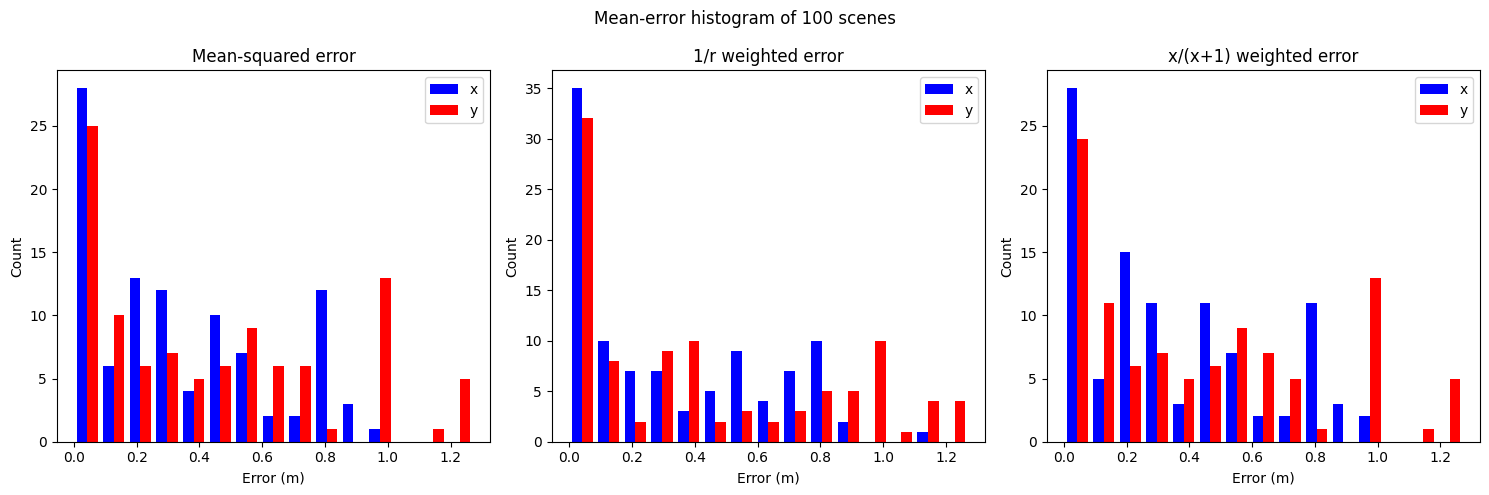

In [110]:
x_error = [error[0] for error in mse_values]
y_error = [error[1] for error in mse_values]

x_error_r =  [error[0] for error in oneRWmse_values]
y_error_r =  [error[1] for error in oneRWmse_values]

x_error_p =  [error[0] for error in RWmse_values]
y_error_p =  [error[1] for error in RWmse_values]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Mean-error histogram of 100 scenes")

ax = plt.subplot(1, 3, 1)
ax.hist([x_error, y_error], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax.legend()
ax.set_title("Mean-squared error")
ax.set_xlabel("Error (m)")
ax.set_ylabel("Count")
ax.get_yaxis().get_major_formatter().set_useOffset(False)

ax1 = plt.subplot(1, 3, 2)
ax1.hist([x_error_r, y_error_r], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax1.legend()
ax1.set_title("1/r weighted error")
ax1.set_xlabel("Error (m)")
ax1.set_ylabel("Count")
ax1.get_yaxis().get_major_formatter().set_useOffset(False)

ax2 = plt.subplot(1, 3, 3)
ax2.hist([x_error_p, y_error_p], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax2.legend()
ax2.set_title("x/(x+1) weighted error")
ax2.set_xlabel("Error (m)")
ax2.set_ylabel("Count")
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

plt.tight_layout()
plt.show()